In [1]:
import numpy as np
import pandas as pd
import to_img

from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi

%matplotlib inline



colors = ['navy', 'turquoise', 'brown', 'red', 'black','green', 'orange', 'pink']

## 1. Data
The data for this project comes from https://www.imdb.com/interfaces/ as extremely large .tsv (tab-seperated) files, the biggest being over 2GB. In order to conduct train the KMeans++ model I will need to combine all of this data. But first, in order to load it without overloading my system I need to apply some data wranging and engineering. The need for each of these files is briefly explained below.

- akas: I need region data so I can narrow the data to 'US' based films.
- basics: contains movie specific info
- name: contains names of cast and crew along with their reference code (nconst)
- principals: contains order of precedence if more than one nconst (person) is referenced to the same role (i.e. lead vs co-directors)
- ratings: holds IMDB user rating and vote counts

I'm handling this huge memory load by using pandas to read load the data in chunk, and filtering out specific columns and values that are irrelevant to the project. The data is then saved to a .csv file to ensure stability (of my machine) that I load back in.

As of right now, there's a bit of SQL at the bottom of this file that I'm tinkering with.
Also, the data dictionary on imdb.com is incorrect. I'll provide one once the data has been trimmed down and consolidated.

### 1.1 Load and Merge Tables
'usecols' is a useful parameter for speeding up the reading in of large files because I can specify just the columns I need pandas to parse.

In .read_csv iterator and chunksize let me specify how much data from each .tsv file will be preprocessed before being recomiled into a dataframe.

In [2]:
def chunks(path,cols):
    """
    Summary: loads .tsv files in chunks, selecting specific features and filtering unnecessary values.
        _
    Args:
        path (string): local address
        cols (list): features to keep
    Returns:
       df_result (pd.DataFrame): preprocessed dataframe
    """
    PATH = path
    my_chunk = 100000
    # sets up the size and parameters of the file reader
    iter_csv = pd.read_csv(
        PATH,
        na_values=['\\N','nan'],
        delimiter='\t',
        iterator=True,
        dtype='object',
        chunksize=my_chunk,
        usecols=cols)
    
    # the following logic follows that when the function is called, if the string arguement passed through as the path parameter matches the case string, a speciic data engineering process is executed for that specific data.
    if 'rating' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
        #df_result = pd.concat([chunk[chunk.averageRating.astype('float') > 5] for chunk in iter_csv])
    elif 'name' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
    elif 'principals' in PATH:
        # there's a number of roles that barely appear in the data.
        #TODO roll these into an 'other'
        principal_roles = ['actor', 'actress','director','writer','producer','composer']
        df_result = pd.concat(
            [chunk[(chunk['ordering'].astype('int') <= 3) & (chunk['category'].isin(principal_roles))]
            for chunk in iter_csv])
        
    elif 'akas' in PATH:
        df_result = pd.concat([chunk[chunk.region == 'US'] for chunk in iter_csv])
        df_result.rename({'titleId': 'tconst'}, axis=1, inplace=True)
    elif 'basics' in PATH:
        # Many films have a list of genres which explodes in dimensionality when one hot encoding. So instead, I'm sticking with the films that're 'quisessentially' a specific genre.
        principle_genres = ['Drama','Comedy','Adventure','Action', 'Horror', 'Thriller', 'Fantasy', 'Crime', 'Family', 'Sci-Fi', 'Mystery',
            'Romance']
        # I also observed a high skew to startYear values so I'm also limiting the scope of the data to just the past 2+ decades.
        df_result = pd.concat([chunk[
            (chunk.titleType == 'movie')
            & (chunk.startYear.between('2000', '2022'))
            & (chunk['genres'].isin(principle_genres))] for chunk in iter_csv])
        
        df_result.startYear = pd.to_numeric(df_result.startYear)
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result[df_result.runtimeMinutes >= 70]
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result.drop('titleType', axis=1)
        
    df_result.columns = map(str.lower, df_result.columns)

    return pd.DataFrame(df_result)

In [3]:

# Each .tsv file is loaded by calling the chunks function using a list of its columns and the local address

col_list = ['tconst','titleType','primaryTitle','startYear','genres','runtimeMinutes']
basics_tsv = '../Data/tsv/basics.tsv'
basics = pd.DataFrame(chunks(basics_tsv,col_list))


col_list = ['titleId','region']
akas_tsv = '../Data/tsv/akas.tsv'
akas = pd.DataFrame(chunks(akas_tsv,col_list))


col_list = ['tconst','ordering','nconst','category'	]
principals_tsv = '../Data/tsv/principals.tsv'
principals = pd.DataFrame(chunks(principals_tsv,col_list))


col_list = ['nconst', 'primaryName']
names_tsv = '../Data/tsv/name.tsv'
names = pd.DataFrame(chunks(names_tsv,col_list))


col_list = ['tconst','averageRating','numVotes']
ratings_tsv = '../Data/tsv/ratings.tsv'
ratings = pd.DataFrame(chunks(ratings_tsv,col_list))


In [4]:
def to_img(data, col_width=4.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Summary: loads .tsv files in chunks, selecting specific features and filtering unnecessary values.
        _
    Args:
        path (string): local address
        cols (list): features to keep
    Returns:
       df_result (pd.DataFrame): preprocessed dataframe
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])s
    return ax.get_figure()

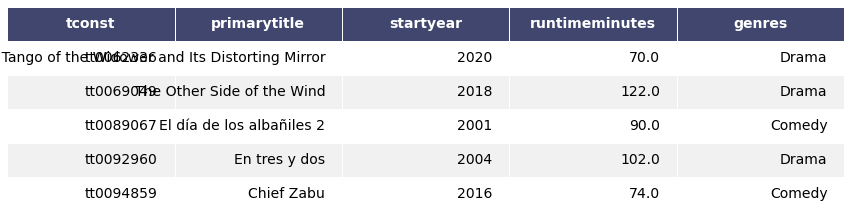

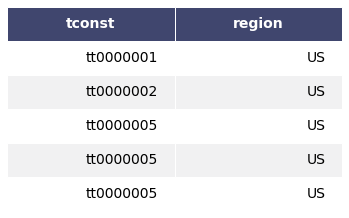

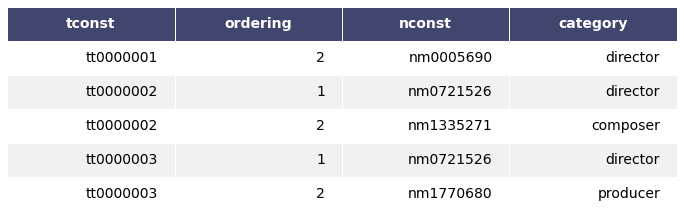

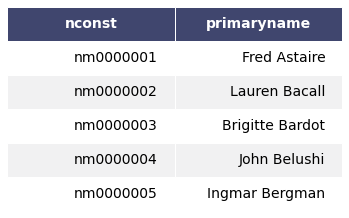

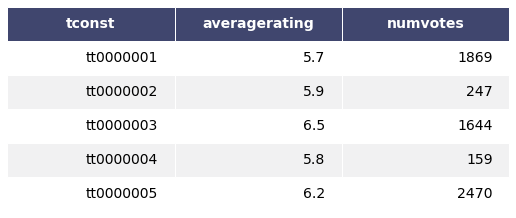

In [6]:
heads = [basics.head(), akas.head(), principals.head(), names.head(), ratings.head()]
table_names = ['basics','akas','principals','names','ratings']
for head, name in zip(heads,table_names):
    fig = to_img(head, header_columns=0, col_width=3)
    fig.savefig(f'../Images/01_data/head_{name}.jpg')

In [ ]:
result = head.to_html()
print(result)

In [ ]:
v

### 1.2 Merging Tables
First, the basics table is filtered by a list of tconst (film specific) values for films that were identified in the akas table as being from the 'US'.
Then the tconst and nconst (person specific) keys are used to merge each table.


In [ ]:

# filtering basics down to only movies from the 'US' region. This'll greatly reduced everything being add from the other tables.
tconst = list(set(akas.tconst.values))
basics = basics[basics['tconst'].isin(tconst)]

data = basics.merge(principals, how='left',on='tconst')
data = data.merge(ratings, how='left',on='tconst')
data = data.merge(names, how='left',on='nconst')

data.drop(['nconst'],axis=1,inplace=True)
data.dropna(inplace=True)
data.to_csv('../Data/data.csv', index=False)
print(len(data))
print(data.info(memory_usage='deep'))
data.head()

### Reload and Inspect Data

In [ ]:
# note the change in memory usage.
data = pd.read_csv('../Data/data.csv')
print(len(data))
data.info(memory_usage='deep')
data.head()

In [ ]:
'''data dictionary
tconst  =   title id of the movie
primarytitle    =   primary title the movie goes by
startyear   =   year realease
runtimeminutes  =   film duration
genres  =   list of each genre the film represents
ordering    =   order of precedence if co-directors/writers/producers
nconst  =   name id or director, writer
category    =   job category7
primaryname =   director/writer name gone by
primaryprofession   =   primary postion of principal
knownfortitles  =   previous works by principle
averagerating   =   films average rating
numvotes    =   number of votes film has received
directors   =   list of directors
writers =   list of writers'''

In [ ]:
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data[data.duplicated() == True]

#data.drop_duplicates(inplace=True)
#data[data.duplicated() == True]


In [ ]:
# check for null values
data[data.isnull().any(axis=1)]

In [ ]:
# just doublechecking.
data.isna().sum()

## 2. Initial EDA: Features
### 2.1 Data Diagnosis

In [ ]:
data.describe(include='all')

### 2.2 Categorical Features
I have to pay special attention here. Note that 'primarytitle' and 'primaryname' would dramatically insrease the dimensionality of the data. Something that I noticed in an earlier iteration is that 'primary' titles are sometimes duplicated, which makes sense because some movies share their title with another, such as in the case of remakes. Therefore, I don't think primary title is a feature I should use.

In [ ]:
data.select_dtypes('object').nunique()

In [ ]:
data.select_dtypes('object')

##### 2.2.a - tsconst
This feature plays a huge factor in my analysis because it's the marker for distinct movies. Sometimes a 'tconst' value will appear multiple times, this happens because some movies have mutiple people associated with it; so a film with a director, actor, and actress will have three seperate entries.

In [ ]:
data.tconst.describe()

##### 2.2.b - primarytitle

In [ ]:
data.primarytitle.value_counts()

##### 2.2.c - genres

In [ ]:
data.genres.value_counts()


##### 2.2.d - category

In [ ]:
data.category.value_counts()

In [ ]:
# further reducing the number of possible categorical values.
keeps = ['actor', 'actress', 'director']
data = data[data.category.isin(keeps)]

##### 2.2.e - primaryname
This is a huge source of dimensionality. For now I'm simply going to drop anyone who appears only once. This is hand during the .tsv file conversion process further up but I may fine tune here in the the future.

In [ ]:
#data = data[data.groupby("primaryname")['primaryname'].transform('size') > 5]
print(data.primaryname.value_counts())
data = data[data.groupby("primaryname")['primaryname'].transform('size') > 1]
data

In [ ]:
print(data.primaryname.value_counts())

In [ ]:
data.select_dtypes('object')

In [ ]:
# so much drama...
for f in data[['genres','category']]:
    sns.countplot(x = f, data = data, palette = 'Set3') # hue = '')
    plt.xticks(rotation=30)
    plt.savefig(f'../Images/cat_countplot_{f}.jpg')
    plt.show()
    

### 2.3 Numeric Features

In [ ]:
old = data.describe()
data.select_dtypes('number').nunique()

In [ ]:
data.select_dtypes('number')

##### 2.3.a - startyear
- The average start year for the films in this selection is 2009.
- This distribution should be plotted with lines indicating centers.

In [ ]:
sns.histplot(data.startyear)
plt.savefig(f'../Images/num_histplot_startyear.jpg')
plt.show()


sns.kdeplot(data.startyear, shade=True, label='data')
plt.savefig(f'../Images/num_kdeplot_startyear.jpg')
plt.show()

##### 2.3.b - averagerating
- This is likely to be some sort of target in the future, linear regression would be great to take this project a step further.

In [ ]:
sns.histplot(data.averagerating)
plt.savefig(f'../Images/num_histplot_averagerating.jpg')
plt.show()

sns.kdeplot(data.averagerating, shade=True, label='data')
plt.savefig(f'../Images/num_kde_averagerating.jpg')
plt.show()


In [ ]:
# Using Numpy I'll first calculate the IQR, then use it to identify and remove outliers found in the averagerating feature.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.savefig(f'../Images/outliers_check_dis_averagerating.jpg')
plt.show()
#TODO come back and trim this

In [ ]:
# trimming off everything above and below the threshold.
# Intuition on this dictates that we want data that extreme outliers can lead to groupings - ansd their centroids, being dragged out due to these skewed data.
data = data[data.averagerating >= iqr_lower]
data = data[data.averagerating <= iqr_upper]

In [ ]:
data.shape
# we've lost only a small number of rows.
#TODO get the original number and show difference.

In [ ]:

# checking out the new distribution using the new IQR.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')

plt.legend()
plt.savefig(f'../Images/outliers_recheck_dis_averagerating.jpg')
plt.show()



In [ ]:
data = data[data.averagerating > iqr_lower]
data = data[data.averagerating < iqr_upper]
data.shape

In [ ]:
sns.kdeplot(data.averagerating, shade=True, label='data')
plt.savefig(f'../Images/num_kde_cleaned_averagerating.jpg')
plt.show()

In [ ]:
# checking out these new summary stats
# the max is a more realistic two hours or so while the mean remains about the same. The standard deviation has also been halved.
data.averagerating.describe(include = 'all')

### 2.4 Feature Associations

In [ ]:
ax = sns.barplot(data=data,x=data.category,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [ ]:
ax = sns.barplot(data=data,x=data.genres,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()
#TODO sort this and amke wider for x labels

In [ ]:
data.category.value_counts()

In [ ]:
data.primarytitle.value_counts()

## 3. Feature Selection & Hyperparameter Tuning
After checking a range of cluster quantities I'm going to use principal component analysis from Sklearn to to reduce the dimensionality of the data. To deal with the categorical variables I'm going to encode them ordinally so can feed the information to the KNN++ model without having to draatically increase me feature space.


#### 3.1 Feature Selection

A key concept with PCA is that the first features considered matter the most - I'd originally struggled to get good metrics because of how I was feeding data in via the pipeline.
primaryname explodes when one hot encoded, primarytitle follows. Since I reduced genres down to a list of quintessential genres (i.e. not a list of genres. "Drama" vs "['Drama', 'Horror']").
In the cell below I'm setting up to run summary analysis on numeric features. Noting the difference in quantity between the appearance of unique values, I'm arranging the pipeline of their unique value.

In [ ]:
ohe = ['category','genres','tconst','primaryname']
for i in ohe:
    print(f'{i} {data[i].nunique()}')

In [ ]:
# preserving data so I can add clusters identified by KMeans++ as a new column later. 
X = data
ordi = OrdinalEncoder()
X['name'] = ordi.fit_transform(pd.DataFrame(X.primaryname))
X['const'] = ordi.fit_transform(pd.DataFrame(X.tconst))

# feature encoding
ohe = ['category','genres']
scal_cols = ['startyear','averagerating','numvotes','runtimeminutes','name','const']
X


### 3.2 Feature Encoding
I'm using a column transformer to encode the X, which is the same as data but with a selection of categorical features ordinally encoded. It will return x_train which I'll then use for finding the optimal number of centroids (k) and components (PCA).

In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        #('ordi', OrdinalEncoder(), ordi),
        ('scaler', StandardScaler(), scal_cols),
        ('ohe', OneHotEncoder(handle_unknown ='ignore'), ohe)
        
        ],remainder='drop')


x_train = preprocessor.fit_transform(X)


In [ ]:
# just looking to see what the training data looks like.
pd.DataFrame(x_train)

### 3.3 Optimal K: Elbow Method

In [ ]:
cs = []
c_dict = {}
n_clusters = [range(1, 15)]
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 30, n_init = 4, random_state = 42)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.savefig('../Images/hypertuning_kmeans_elbow1.jpg')
plt.show()


In [ ]:
# Using the best k shown by the elbow method to train a new model.
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 20, n_init = 8, random_state = 42)
kmeans.fit(x_train)

# saving for PCA
labels = set(kmeans.labels_)
# saving for PCA
y_pred = kmeans.predict(x_train)
# saving this to compare with final model
old_inertia = kmeans.inertia_
# labels for plot legend
target_labels = [f'Cluster {1+x}' for x in labels]
print(f'Model Inertia: {kmeans.inertia_}')
print(f'Model Label: {labels}')

### 3.4 Principal Component Analysis


In [ ]:
n_components = 2
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)

In [ ]:
plt.figure(1, figsize=(14, 8))
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {n_components} Items')
plt.savefig('../Images/hypertuning_PCA_first_2.jpg')
plt.show()

In [ ]:
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))


In [ ]:
x_train.shape[1]

#### 3.4.1 Finding Optimal N-Components Using Optimal K
In order to find the optimal number of components to abstract the feature set into I need to analyze the entire table to find both the total variance and its 95% percentile. The number of components that can reduce variance by 5% is what we'll go with.

In [ ]:
n_components = x_train.shape[1]
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)

In [ ]:

total_variance = sum(pca.explained_variance_)
print('Total Variance in our dataset is: ', total_variance)
var_95 = total_variance * 0.95
print('The 95% variance we want to have is: ', var_95)
print('')
# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=['PCA Comp', 'Explained Variance'])

# Trying to hit 95%

d = 1
v = []
best = []

for i in range(len(a)):
    if len(v) > a.shape[0]*.9:
        if sum(v[-5:])/5 == v[:-1]:
            break
    else:
        v.append(sum(a['Explained Variance'][0:d]))
        if d%5 == 0:
            print(f'Variance explained with {d} compononets: ', sum(a['Explained Variance'][0:d]))
            if sum(a['Explained Variance'][0:d]) >= var_95:
                best.append((d,sum(a['Explained Variance'][0:d])))
        d += 1


best_c = best[0][0]
best_v = best[0][1]


# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c='r')
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 95% e.v.
plt.axvline(best_c,linestyle=':', label='n_components - 95% explained', c ='blue')
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate(f'{best_c} eigenvectors used to explain 95% variance', xy=(best_c, pca.explained_variance_ratio_[best_c]), 
             xytext=(best_c+10, pca.explained_variance_ratio_[5]),
            arrowprops=dict(facecolor='blue', shrink=0.05))
plt.savefig('../Images/hypertuning_PCA_explanatory_components.jpg')
plt.show()

print(f'The best is {best_c} components which yields {best_v}')

#### 3.4.2 Rechecking For Optimal K-Means Using Optimal N-Components
Using PCA with this optimal number of components to add a preprocessing layer to the data before applying KMeans.

In [ ]:
pca = PCA(n_components=best_c)
X_r = pca.fit_transform(x_train)

In [ ]:
inertia = []
cs = []
n_clusters = [range(1, 11)]
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
    kmeans.fit(X_r)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.savefig('../Images/hypertuning_kmeans_elbow2.jpg')
plt.show()

### 4. Training KMeans ++ with PCA

In [ ]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
kmeans.fit(X_r)

In [ ]:
y_pred = kmeans.predict(X_r)
y_pred


In [ ]:
data['cluster'] = y_pred
data

### 5. KMeans++ Model and PCA Evaluation

In [ ]:
print(f'old inertia: {old_inertia}')
print(f'new inertia: {kmeans.inertia_}')
print(f'change:      {old_inertia-kmeans.inertia_}')

In [ ]:
labels = set(kmeans.labels_)
target_labels = [f'Cluster {x}' for x in labels]
target_labels


plt.figure(1, figsize=(14, 8))

colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','green', 'orange','pink']
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)



plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {best_c} Items')
plt.savefig('../Images/final_clusters.jpg')
plt.show()





### 6. Cluster Analysis

In [ ]:

val_counts = []
for i in range(len(target_labels)):
    ax = sns.countplot(data=data[data.cluster == i], x='genres')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig(f'../Images/cluster_analysis_{i}_genres.jpg')
    plt.show()


In [ ]:
val_counts = []
for i in range(len(target_labels)):
    ax = sns.countplot(data=data[data.cluster == i], x='category')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig(f'../Images/cluster_analysis_{i}_categories.jpg')
    plt.show()

In [ ]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].primaryname.value_counts()[:5])

In [ ]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].primarytitle.value_counts()[:5])

In [ ]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].genres.value_counts()[:5])

In [ ]:
for i in range(len(target_labels)):
    print(np.mean(data[data.cluster == i].numvotes))

In [ ]:
for i in range(len(target_labels)):
    print(np.mean(data[data.cluster == i].startyear))